In [1]:
import os
import re
import datetime as dt
import json
from collections import namedtuple
from collections import Counter
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

Define some helper methods and data structures

In [2]:
GeoExtent = namedtuple('GeoExtent', ['x_min', 'y_max', 'x_max', 'y_min'])
GeoAffine = namedtuple('GeoAffine', ['ul_x', 'x_res', 'rot_1', 'ul_y', 'rot_2', 'y_res'])
GeoCoordinate = namedtuple('GeoCoordinate', ['x', 'y'])
RowColumn = namedtuple('RowColumn', ['row', 'column'])
RowColumnExtent = namedtuple('RowColumnExtent', ['start_row', 'start_col', 'end_row', 'end_col'])

In [3]:
def geospatial_hv(h, v, loc):
    """
    Geospatial extent and 30m affine for a given ARD grid location.
    """
    xmin = loc.x_min + h * 5000 * 30
    xmax = loc.x_min + h * 5000 * 30 + 5000 * 30
    ymax = loc.y_max - v * 5000 * 30
    ymin = loc.y_max - v * 5000 * 30 - 5000 * 30

    return (GeoExtent(x_min=xmin, x_max=xmax, y_max=ymax, y_min=ymin),
            GeoAffine(ul_x=xmin, x_res=30, rot_1=0, ul_y=ymax, rot_2=0, y_res=-30))

In [4]:
def geo_to_rowcol(affine, coord):
    """
    Transform geo-coordinate to row/col given a reference affine.
    
    Yline = (Ygeo - GT(3) - Xpixel*GT(4)) / GT(5)
    Xpixel = (Xgeo - GT(0) - Yline*GT(2)) / GT(1)
    """
    row = (coord.y - affine.ul_y - affine.ul_x * affine.rot_2) / affine.y_res
    col = (coord.x - affine.ul_x - affine.ul_y * affine.rot_1) / affine.x_res

    return RowColumn(row=int(row),
                     column=int(col))

In [5]:
def rowcol_to_geo(affine, rowcol):
    """
    Transform a row/col into a geospatial coordinate given reference affine.
    
    Xgeo = GT(0) + Xpixel*GT(1) + Yline*GT(2)
    Ygeo = GT(3) + Xpixel*GT(4) + Yline*GT(5)
    """
    x = affine.ul_x + rowcol.column * affine.x_res + rowcol.row * affine.rot_1
    y = affine.ul_y + rowcol.column * affine.rot_2 + rowcol.row * affine.y_res

    return GeoCoordinate(x=x, y=y)

In [6]:
def load_cache(file):
    """
    Load the cache file and split the data into the image IDs and values
    """
    data = np.load(file)
    return data['Y'], data['image_IDs']

In [7]:
def find_file(file_ls, string):
    """
    Return the first str in a list of strings that contains string.
    """
    gen = filter(lambda x: string in x, file_ls)
    return next(gen, None)

In [8]:
def imageid_date(image_ids):
    """
    Extract the ordinal day from the ARD image name.
    """
    return np.array([dt.datetime.strptime(d[15:23], '%Y%m%d').toordinal()
                     for d in image_ids])

In [9]:
def mask_daterange(dates):
    """
    Create a mask for values outside of the global BEGIN_DATE and END_DATE.
    """

    return np.logical_and(dates >= BEGIN_DATE.toordinal(), dates < END_DATE.toordinal())

In [10]:
def find_chipcurve(results_chip, coord):
    """
    Find the results for the specified coordinate.
    """
    with open(results_chip, 'r') as f:
        results = json.load(f)
    
    gen = filter(lambda x: coord.x == x['x'] and coord.y == x['y'], results)
    
    return next(gen, None)

In [11]:
def extract_cachepoint(coord):
    """
    Extract the spectral values from the cache file.
    """

    rowcol = geo_to_rowcol(PIXEL_AFFINE, coord)
    
    data, image_ids = load_cache(find_file(CACHE_INV, 'r{}'.format(rowcol.row)))
    
    dates = imageid_date(image_ids)
           
    return image_ids, data[:, :, rowcol.column], dates
   

In [12]:
def extract_jsoncurve(coord):
    """
    Extract the pyccd information from the json file representing a chip of results.
    """
    pixel_rowcol = geo_to_rowcol(PIXEL_AFFINE, coord)
    pixel_coord = rowcol_to_geo(PIXEL_AFFINE, pixel_rowcol)
    
    chip_rowcol = geo_to_rowcol(CHIP_AFFINE, coord)
    chip_coord = rowcol_to_geo(CHIP_AFFINE, chip_rowcol)
    
    file = find_file(JSON_INV, 'H{:02d}V{:02d}_{}_{}.json'.format(H, V, chip_coord.x, chip_coord.y))
    result = find_chipcurve(file, pixel_coord)
    
    return json.loads(result['result'])

In [13]:
def predicts(days, coef, intercept):
    return (intercept + coef[0] * days +
            coef[1]*np.cos(days*1*2*np.pi/365.25) + coef[2]*np.sin(days*1*2*np.pi/365.25) +
            coef[3]*np.cos(days*2*2*np.pi/365.25) + coef[4]*np.sin(days*2*2*np.pi/365.25) +
            coef[5]*np.cos(days*3*2*np.pi/365.25) + coef[6]*np.sin(days*3*2*np.pi/365.25))

In [14]:
def arcpaste_to_coord(string):
    pieces = string.split()
    
    return GeoCoordinate(x=float(re.sub(',', '', pieces[0])),
                         y=float(re.sub(',', '', pieces[1])))

Setup file locations

In [15]:
JSON_DIR = r'Z:\sites\ms\pyccd-results\H19V14\2017.08.18\json'
JSON_INV = [os.path.join(JSON_DIR, f) for f in os.listdir(JSON_DIR)]
CACHE_DIR = r'Z:\sites\ms\ARD\h19v14\cache'
CACHE_INV = [os.path.join(CACHE_DIR, f) for f in os.listdir(CACHE_DIR)]

In [16]:
arc_paste = '284,424.372  1,214,793.211'
coord = arcpaste_to_coord(arc_paste)

CONUS_EXTENT = GeoExtent(x_min=-2565585,
                         y_min=14805,
                         x_max=2384415,
                         y_max=3314805)

H = 19
V = 14
EXTENT, PIXEL_AFFINE = geospatial_hv(H, V, CONUS_EXTENT)
CHIP_AFFINE = GeoAffine(ul_x=PIXEL_AFFINE.ul_x, x_res=3000, rot_1=0, ul_y=PIXEL_AFFINE.ul_y, rot_2=0, y_res=-3000)



In [17]:
print("entered coord= ", coord)
pixel_rowcol = geo_to_rowcol(PIXEL_AFFINE, coord)
pixel_coord = rowcol_to_geo(PIXEL_AFFINE, pixel_rowcol)

chip_rowcol = geo_to_rowcol(CHIP_AFFINE, coord)
chip_coord = rowcol_to_geo(CHIP_AFFINE, chip_rowcol)

# pixel_rowcol is used to find the cache file.  There is one cache file per row of the tile.
print("pixel_rowcol= ", pixel_rowcol)

print("pixel_coord= ", pixel_coord)
print("chip_rowcol= ", chip_rowcol)

# chip_coord is used to find the json file.  There are 2500 chips and json files per tile.  
# The chip_coord gives the upper left coordinate which is used to identify the chip and corresponding json file.
print("chip_coord= ", chip_coord)
print("EXTENT= ", EXTENT)

entered coord=  GeoCoordinate(x=284424.372, y=1214793.211)
pixel_rowcol=  RowColumn(row=0, column=0)
pixel_coord=  GeoCoordinate(x=284415, y=1214805)
chip_rowcol=  RowColumn(row=0, column=0)
chip_coord=  GeoCoordinate(x=284415, y=1214805)
EXTENT=  GeoExtent(x_min=284415, y_max=1214805, x_max=434415, y_min=1064805)


In [18]:
# Extract the pyccd results from the appropriate json file
results = extract_jsoncurve(coord)


In [19]:
results.keys()

dict_keys(['algorithm', 'processing_mask', 'change_models', 'procedure'])

In [20]:
file = find_file(JSON_INV, 'H{:02d}V{:02d}_{}_{}.json'.format(H, V, chip_coord.x, chip_coord.y))
full_result = find_chipcurve(file, pixel_coord)

In [21]:
full_result["result"]

'{"algorithm":"lcmap-pyccd:2017.08.18","processing_mask":[0,1,1,0,0,0,0,1,0,1,1,1,1,1,1,0,1,0,0,1,0,0,1,1,0,1,0,1,1,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,1,0,1,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,1,0,0,1,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,1,1,0,0,1,1,1,0,1,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,1,0,1,1,0,1,0,0,0,0,0,0,1,1,1,1,0,0,0,0,1,1,0,0,1,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,1,0,1,1,1,0,0,1,1,0,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,1,1,0,1,0,0,0,1,1,0,0,1,0,0,0,1,1,0,1,0,1,1,1,0,1,1,1,0,0,1,0,0,0,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1,1,0,0,0,1,0,0,0,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,1,1,1,0,0,0,1,0,1,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,1,0,1,1,0,1,1,1,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,1,1,0,1,1,0,1,1,1,1,1,0,0,

In [22]:
res = np.array((1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0), dtype=np.bool)

In [23]:
len(res)

1544

In [24]:
for key in full_result.keys():
    print(key)
for key in full_result.keys():
    print(full_result[key])

chip_x
chip_y
algorithm
x
y
chip_update_requested
inputs_md5
inputs_url
result
result_md5
result_ok
result_produced
284415
1214805
lcmap-pyccd:2017.08.18
284415
1214805
2017-10-29T00:10:15.284000
not implemented
http://lcmap-test.cr.usgs.gov/v1/landsat/chips?x=284415&y=1214805&acquired=1982-01-01/2015-12-31&ubid=LANDSAT_5/TM/SRB5&ubid=LANDSAT_8/OLI_TIRS/SRB6&ubid=LANDSAT_4/TM/SRB5&ubid=LANDSAT_7/ETM/SRB5&ubid=LANDSAT_8/OLI_TIRS/BTB10&ubid=LANDSAT_5/TM/BTB6&ubid=LANDSAT_7/ETM/BTB6&ubid=LANDSAT_4/TM/BTB6&ubid=LANDSAT_7/ETM/SRB7&ubid=LANDSAT_5/TM/SRB7&ubid=LANDSAT_4/TM/SRB7&ubid=LANDSAT_8/OLI_TIRS/SRB7&ubid=LANDSAT_4/TM/PIXELQA&ubid=LANDSAT_7/ETM/PIXELQA&ubid=LANDSAT_5/TM/PIXELQA&ubid=LANDSAT_8/OLI_TIRS/PIXELQA&ubid=LANDSAT_4/TM/SRB3&ubid=LANDSAT_5/TM/SRB3&ubid=LANDSAT_8/OLI_TIRS/SRB4&ubid=LANDSAT_7/ETM/SRB3&ubid=LANDSAT_5/TM/SRB1&ubid=LANDSAT_4/TM/SRB1&ubid=LANDSAT_7/ETM/SRB1&ubid=LANDSAT_8/OLI_TIRS/SRB2&ubid=LANDSAT_5/TM/SRB2&ubid=LANDSAT_7/ETM/SRB2&ubid=LANDSAT_8/OLI_TIRS/SRB3&ubid=LAN

In [25]:
# Extract the ARD observations from the appropriate cache file
imageIDs, data, dates = extract_cachepoint(coord)


In [26]:
# BEGIN_DATE = dt.datetime.fromordinal(results["change_models"][0]["start_day"])
# BEGIN_DATE = dt.datetime.fromordinal(dates[0])
# END_DATE = dt.datetime.fromordinal(results["change_models"][-1]["break_day"])
# END_DATE = dt.datetime.fromordinal(dates[len(results["processing_mask"])-1])

BEGIN_DATE = dt.datetime(1982, 1, 1, 0, 0)
END_DATE = dt.datetime(2015, 12, 31, 0, 0)

print(BEGIN_DATE, END_DATE)

1982-01-01 00:00:00 2015-12-31 00:00:00


In [27]:
date_mask = mask_daterange(dates=dates)


In [28]:
# Make a mask based on the ARD QA band to remove fill (value 1)
qa = data[-1]
qa_mask = np.ones_like(qa, dtype=np.bool)
qa_mask[qa == 1] = False
qa_in = qa_mask[date_mask]
qa_out = qa_mask[~date_mask]

print(len(qa_mask))
print(len(qa_in))
print(len(qa_out))

2595
2420
175


In [29]:
# spectral data from the cache files
blue = data[1]
blue_nofill = blue[blue != -9999]
print("all blue =", len(blue))
print("blue no fill =", len(blue_nofill))
print("json processing mask =", len(res))
print("coords =", coord)

all blue = 2595
blue no fill = 1501
json processing mask = 1544
coords = GeoCoordinate(x=284424.372, y=1214793.211)


In [30]:
file

'Z:\\sites\\ms\\pyccd-results\\H19V14\\2017.08.18\\json\\H19V14_284415_1214805.json'

In [31]:
len(blue)

2595

Setup geospatial and temporal information

In [32]:
dates_in = dates[date_mask]
dates_out = dates[~date_mask]


In [33]:
test_dates_length = (len(dates) == len(np.unique(dates)))
print("dates = unique dates: ", test_dates_length)
print("Length of processing mask: ", len(results["processing_mask"]))
print("length of dates_in: ", len(dates_in))
print("length of dates_out: ", len(dates_out))
no_fill_dates_in = dates_in[qa_in]
print("length of dates with fill removed: ", len(no_fill_dates_in))


dates = unique dates:  True
Length of processing mask:  2420
length of dates_in:  2420
length of dates_out:  175
length of dates with fill removed:  1395


In [34]:
results

{'algorithm': 'lcmap-pyccd:2017.08.18',
 'change_models': [{'blue': {'coefficients': [-0.0022787978799332625,
     28.59019317679263,
     14.816742165613768,
     12.907135560631465,
     26.088092067064366,
     -13.962126185026117,
     1.5779278712715383],
    'intercept': 1994.4944942712127,
    'magnitude': 141.9201379403047,
    'rmse': 98.35404863909835},
   'break_day': 732449,
   'change_probability': 1,
   'curve_qa': 8,
   'end_day': 732442,
   'green': {'coefficients': [-0.009748114346226374,
     10.609829810865692,
     42.76047468607127,
     -8.327899029851903,
     14.47572543003952,
     -20.33719266443131,
     -4.538023937598931],
    'intercept': 7589.132600228755,
    'magnitude': 181.26443361335305,
    'rmse': 89.48467716433332},
   'nir': {'coefficients': [-0.019149492133887055,
     -854.4442828435829,
     168.28154366607652,
     -130.7397271365914,
     -259.68358650882186,
     152.86645046995204,
     0.0],
    'intercept': 16256.099135460754,
    'magni

In [35]:
dates_unique = np.unique(dates_in)
print(len(dates_unique))
print(len(dates_in))
print(dt.datetime.fromordinal(dates_in[0]))
print(dt.datetime.fromordinal(dates_in[-1]))
print(len(dates))
print(len(np.unique(dates)))

2420
2420
1982-12-12 00:00:00
2015-12-29 00:00:00
2595
2595


#### Test that the lengths of the processing mask and dates_in arrays are equal, take action if they aren't

In [36]:
if len(dates_in) == len(results["processing_mask"]):
    print("The number of observations is consistent with the length of the PyCCD internal processing mask.\n"
          "No changes to the input observations are necessary.")

if len(np.unique(dates_in)) != len(dates_in) and len(np.unique(dates_in)) == len(results["processing_mask"]):
    print("There is a duplicate date occurrence in observations.  Removing duplicate occurrences makes the "
          "number of observations consistent with the length of the PyCCD internal processing mask.")

    dupes = [item for item, count in Counter(dates).items() if count > 1]

    dates, ind, counts = np.unique(dates, return_index=True, return_counts=True)

    print("Duplicate dates: \n\t", dates[:, ind])

    data = data[:, ind]

    date_mask = mask_daterange(dates)

    dates_in = dates[date_mask]

    dates_out = dates[~date_mask]

if len(dates_in) != len(results["processing_mask"]):
    print("There is an inconsistency in the length of the processing mask array, PIXELQA will be used instead")
    
    # get_pqa_mask()

The number of observations is consistent with the length of the PyCCD internal processing mask.
No changes to the input observations are necessary.


In [37]:
# rescale the brightness temperature to match the predicted values
temp_thermal_data = np.copy(data[6])
# temp_thermal_data[ temp_thermal_data != -9999 ] = temp_thermal_data[ temp_thermal_data != -9999 ] * 10 - 27315
temp_thermal_data[qa_mask] = temp_thermal_data[qa_mask] * 10 - 27315
data[6] = np.copy(temp_thermal_data)

In [38]:
data_in = data[:, date_mask]
data_out = data[:, ~date_mask]

print(np.shape(data_in))
print(np.shape(data_out))


(8, 2420)
(8, 175)


In [39]:
# Check the processing mask values against PIXELQA assuming they both begin at the same start date
print("length of internal processing mask: ", len(results["processing_mask"]))
print("length of ARD observations: ", len(qa))
print("length of date-masked ARD obs.: ", len(qa_in))

# Undesirable values to have for your Pixel QA at a given observation'
values_to_look_for = [1, 72, 80, 112, 96, 136, 144, 160, 176, 224, 336,
                      386, 834, 898, 1346, 388, 836, 900, 1348,
                      328, 392, 840, 904, 1350, 368, 400, 432, 
                      848, 880, 912, 944, 1352, 352, 368, 416, 
                      432, 480, 864, 880, 928, 944, 992, 834, 
                      836, 840, 848, 864, 880, 898, 900, 904, 
                      912, 928, 944, 992, 1346, 1348, 1350, 1352]

clear_vals = [322, 324, 66, 68]

qa_check = qa[date_mask]

length of internal processing mask:  2420
length of ARD observations:  2595
length of date-masked ARD obs.:  2420


In [40]:
counter = 0
for ind, m in enumerate(results["processing_mask"]):
    try:
        for v in values_to_look_for:
            if v == qa_check[ind] and m == 1:
                counter += 1
                print("qa =", v, ".... list index =", ind, "....", m, " .... date =", dt.datetime.fromordinal(dates_in[ind]))
                break
        for v in clear_vals:
            if v == qa_check[ind] and m is False:
                counter += 1
                print("qa =", v, ".... list index =", ind, "....", m, " .... date =", dt.datetime.fromordinal(dates_in[ind]))
                break
    except IndexError:
        # print(ind)
        continue
print(counter)

0


In [41]:
counter = 0
for ind, m in enumerate(results["processing_mask"]):
    try:
        if qa_check[ind] == 1 and m == 1:
            counter += 1
            print("list index =", ind, "....", m, " .... date =", dt.datetime.fromordinal(dates_in[ind]))
            break
    except IndexError:
        # print(ind)
        continue
print(counter)

0


In [42]:
"""
A duplicate obs. was used at some point by pyccd before index 1414 (2013-04-04)
"""

'\nA duplicate obs. was used at some point by pyccd before index 1414 (2013-04-04)\n'

In [43]:
test_results = list(results["processing_mask"])

del test_results[1487]

len(test_results)

2419

In [44]:
counter = 0
for ind, m in enumerate(test_results):
    try:
        for v in values_to_look_for:
            if v == qa_check[ind] and m == 1:
                counter += 1
                print("qa =", v, ".... list index =", ind, "....", m, " .... date =", dt.datetime.fromordinal(dates_in[ind]))
                break
        for v in clear_vals:
            if v == qa_check[ind] and m == 0:
                counter += 1
                print("qa =", v, ".... list index =", ind, "....", m, " .... date =", dt.datetime.fromordinal(dates_in[ind]))
                break
    except IndexError:
        print(ind)
        continue
print(counter)

qa = 66 .... list index = 8 .... 0  .... date = 1984-05-06 00:00:00
qa = 66 .... list index = 21 .... 0  .... date = 1984-10-13 00:00:00
qa = 66 .... list index = 77 .... 0  .... date = 1986-05-28 00:00:00
qa = 66 .... list index = 94 .... 0  .... date = 1986-09-17 00:00:00
qa = 66 .... list index = 95 .... 0  .... date = 1986-09-24 00:00:00
qa = 66 .... list index = 122 .... 0  .... date = 1987-05-22 00:00:00
qa = 66 .... list index = 243 .... 0  .... date = 1989-11-19 00:00:00
qa = 66 .... list index = 267 .... 0  .... date = 1990-08-02 00:00:00
qa = 66 .... list index = 422 .... 0  .... date = 1993-11-23 00:00:00
qa = 66 .... list index = 489 .... 0  .... date = 1995-04-19 00:00:00
qa = 66 .... list index = 533 .... 0  .... date = 1996-03-04 00:00:00
qa = 66 .... list index = 536 .... 0  .... date = 1996-03-20 00:00:00
qa = 66 .... list index = 674 .... 0  .... date = 1999-02-09 00:00:00
qa = 66 .... list index = 685 .... 0  .... date = 1999-05-16 00:00:00
qa = 66 .... list index = 

qa = 66 .... list index = 1884 .... 0  .... date = 2010-08-17 00:00:00
qa = 1 .... list index = 1891 .... 1  .... date = 2010-09-04 00:00:00
qa = 66 .... list index = 1892 .... 0  .... date = 2010-09-10 00:00:00
qa = 1 .... list index = 1894 .... 1  .... date = 2010-09-12 00:00:00
qa = 66 .... list index = 1896 .... 0  .... date = 2010-09-19 00:00:00
qa = 1 .... list index = 1899 .... 1  .... date = 2010-09-28 00:00:00
qa = 66 .... list index = 1901 .... 0  .... date = 2010-10-05 00:00:00
qa = 1 .... list index = 1902 .... 1  .... date = 2010-10-06 00:00:00
qa = 66 .... list index = 1904 .... 0  .... date = 2010-10-13 00:00:00
qa = 1 .... list index = 1905 .... 1  .... date = 2010-10-14 00:00:00
qa = 66 .... list index = 1907 .... 0  .... date = 2010-10-21 00:00:00
qa = 1 .... list index = 1908 .... 1  .... date = 2010-10-22 00:00:00
qa = 66 .... list index = 1909 .... 0  .... date = 2010-10-28 00:00:00
qa = 66 .... list index = 1910 .... 0  .... date = 2010-10-29 00:00:00
qa = 1 .... 

In [45]:
for ind, date in enumerate(dates_in):
    print(ind, "...", dt.datetime.fromordinal(date))

0 ... 1982-12-12 00:00:00
1 ... 1982-12-19 00:00:00
2 ... 1983-01-04 00:00:00
3 ... 1983-01-13 00:00:00
4 ... 1984-04-11 00:00:00
5 ... 1984-04-13 00:00:00
6 ... 1984-04-20 00:00:00
7 ... 1984-04-27 00:00:00
8 ... 1984-05-06 00:00:00
9 ... 1984-05-13 00:00:00
10 ... 1984-05-29 00:00:00
11 ... 1984-06-14 00:00:00
12 ... 1984-06-23 00:00:00
13 ... 1984-06-30 00:00:00
14 ... 1984-07-09 00:00:00
15 ... 1984-07-16 00:00:00
16 ... 1984-08-26 00:00:00
17 ... 1984-09-04 00:00:00
18 ... 1984-09-11 00:00:00
19 ... 1984-09-18 00:00:00
20 ... 1984-10-04 00:00:00
21 ... 1984-10-13 00:00:00
22 ... 1984-10-29 00:00:00
23 ... 1984-11-05 00:00:00
24 ... 1984-11-07 00:00:00
25 ... 1984-11-21 00:00:00
26 ... 1984-11-23 00:00:00
27 ... 1984-11-30 00:00:00
28 ... 1984-12-07 00:00:00
29 ... 1984-12-09 00:00:00
30 ... 1984-12-23 00:00:00
31 ... 1985-01-01 00:00:00
32 ... 1985-01-08 00:00:00
33 ... 1985-01-10 00:00:00
34 ... 1985-01-17 00:00:00
35 ... 1985-01-24 00:00:00
36 ... 1985-01-26 00:00:00
37 ... 1985

425 ... 1993-12-16 00:00:00
426 ... 1993-12-18 00:00:00
427 ... 1993-12-25 00:00:00
428 ... 1994-01-01 00:00:00
429 ... 1994-01-10 00:00:00
430 ... 1994-01-17 00:00:00
431 ... 1994-01-19 00:00:00
432 ... 1994-02-02 00:00:00
433 ... 1994-02-11 00:00:00
434 ... 1994-02-18 00:00:00
435 ... 1994-02-27 00:00:00
436 ... 1994-03-06 00:00:00
437 ... 1994-03-15 00:00:00
438 ... 1994-03-22 00:00:00
439 ... 1994-03-31 00:00:00
440 ... 1994-04-07 00:00:00
441 ... 1994-04-09 00:00:00
442 ... 1994-04-16 00:00:00
443 ... 1994-04-23 00:00:00
444 ... 1994-05-02 00:00:00
445 ... 1994-05-11 00:00:00
446 ... 1994-05-18 00:00:00
447 ... 1994-05-25 00:00:00
448 ... 1994-05-27 00:00:00
449 ... 1994-06-03 00:00:00
450 ... 1994-06-12 00:00:00
451 ... 1994-06-19 00:00:00
452 ... 1994-06-26 00:00:00
453 ... 1994-07-05 00:00:00
454 ... 1994-07-12 00:00:00
455 ... 1994-07-21 00:00:00
456 ... 1994-07-28 00:00:00
457 ... 1994-07-30 00:00:00
458 ... 1994-08-06 00:00:00
459 ... 1994-08-13 00:00:00
460 ... 1994-08-15 0

833 ... 2000-10-02 00:00:00
834 ... 2000-10-08 00:00:00
835 ... 2000-10-09 00:00:00
836 ... 2000-10-10 00:00:00
837 ... 2000-10-16 00:00:00
838 ... 2000-10-17 00:00:00
839 ... 2000-10-18 00:00:00
840 ... 2000-10-24 00:00:00
841 ... 2000-10-25 00:00:00
842 ... 2000-10-26 00:00:00
843 ... 2000-11-01 00:00:00
844 ... 2000-11-03 00:00:00
845 ... 2000-11-09 00:00:00
846 ... 2000-11-11 00:00:00
847 ... 2000-11-17 00:00:00
848 ... 2000-11-19 00:00:00
849 ... 2000-11-25 00:00:00
850 ... 2000-11-26 00:00:00
851 ... 2000-11-27 00:00:00
852 ... 2000-12-03 00:00:00
853 ... 2000-12-04 00:00:00
854 ... 2000-12-05 00:00:00
855 ... 2000-12-12 00:00:00
856 ... 2000-12-19 00:00:00
857 ... 2000-12-20 00:00:00
858 ... 2000-12-21 00:00:00
859 ... 2000-12-29 00:00:00
860 ... 2001-01-04 00:00:00
861 ... 2001-01-05 00:00:00
862 ... 2001-01-06 00:00:00
863 ... 2001-01-20 00:00:00
864 ... 2001-01-21 00:00:00
865 ... 2001-01-22 00:00:00
866 ... 2001-01-28 00:00:00
867 ... 2001-01-30 00:00:00
868 ... 2001-02-05 0

1187 ... 2004-01-30 00:00:00
1188 ... 2004-01-31 00:00:00
1189 ... 2004-02-07 00:00:00
1190 ... 2004-02-08 00:00:00
1191 ... 2004-02-15 00:00:00
1192 ... 2004-02-16 00:00:00
1193 ... 2004-02-22 00:00:00
1194 ... 2004-02-23 00:00:00
1195 ... 2004-03-01 00:00:00
1196 ... 2004-03-02 00:00:00
1197 ... 2004-03-03 00:00:00
1198 ... 2004-03-09 00:00:00
1199 ... 2004-03-10 00:00:00
1200 ... 2004-03-11 00:00:00
1201 ... 2004-03-17 00:00:00
1202 ... 2004-03-18 00:00:00
1203 ... 2004-03-19 00:00:00
1204 ... 2004-03-26 00:00:00
1205 ... 2004-03-27 00:00:00
1206 ... 2004-04-02 00:00:00
1207 ... 2004-04-03 00:00:00
1208 ... 2004-04-04 00:00:00
1209 ... 2004-04-10 00:00:00
1210 ... 2004-04-18 00:00:00
1211 ... 2004-04-19 00:00:00
1212 ... 2004-04-20 00:00:00
1213 ... 2004-04-26 00:00:00
1214 ... 2004-04-27 00:00:00
1215 ... 2004-04-28 00:00:00
1216 ... 2004-05-04 00:00:00
1217 ... 2004-05-05 00:00:00
1218 ... 2004-05-06 00:00:00
1219 ... 2004-05-21 00:00:00
1220 ... 2004-05-22 00:00:00
1221 ... 2004-

1623 ... 2008-02-27 00:00:00
1624 ... 2008-03-04 00:00:00
1625 ... 2008-03-05 00:00:00
1626 ... 2008-03-06 00:00:00
1627 ... 2008-03-12 00:00:00
1628 ... 2008-03-13 00:00:00
1629 ... 2008-03-14 00:00:00
1630 ... 2008-03-20 00:00:00
1631 ... 2008-03-21 00:00:00
1632 ... 2008-03-22 00:00:00
1633 ... 2008-03-30 00:00:00
1634 ... 2008-04-05 00:00:00
1635 ... 2008-04-06 00:00:00
1636 ... 2008-04-07 00:00:00
1637 ... 2008-04-13 00:00:00
1638 ... 2008-04-14 00:00:00
1639 ... 2008-04-15 00:00:00
1640 ... 2008-04-21 00:00:00
1641 ... 2008-04-22 00:00:00
1642 ... 2008-04-23 00:00:00
1643 ... 2008-04-29 00:00:00
1644 ... 2008-04-30 00:00:00
1645 ... 2008-05-01 00:00:00
1646 ... 2008-05-09 00:00:00
1647 ... 2008-05-16 00:00:00
1648 ... 2008-05-17 00:00:00
1649 ... 2008-05-23 00:00:00
1650 ... 2008-05-25 00:00:00
1651 ... 2008-05-31 00:00:00
1652 ... 2008-06-01 00:00:00
1653 ... 2008-06-02 00:00:00
1654 ... 2008-06-08 00:00:00
1655 ... 2008-06-09 00:00:00
1656 ... 2008-06-10 00:00:00
1657 ... 2008-

1915 ... 2010-11-14 00:00:00
1916 ... 2010-11-21 00:00:00
1917 ... 2010-11-23 00:00:00
1918 ... 2010-11-30 00:00:00
1919 ... 2010-12-01 00:00:00
1920 ... 2010-12-07 00:00:00
1921 ... 2010-12-08 00:00:00
1922 ... 2010-12-09 00:00:00
1923 ... 2010-12-17 00:00:00
1924 ... 2010-12-23 00:00:00
1925 ... 2010-12-24 00:00:00
1926 ... 2010-12-31 00:00:00
1927 ... 2011-01-01 00:00:00
1928 ... 2011-01-02 00:00:00
1929 ... 2011-01-08 00:00:00
1930 ... 2011-01-24 00:00:00
1931 ... 2011-01-26 00:00:00
1932 ... 2011-02-02 00:00:00
1933 ... 2011-02-10 00:00:00
1934 ... 2011-02-11 00:00:00
1935 ... 2011-02-19 00:00:00
1936 ... 2011-02-25 00:00:00
1937 ... 2011-02-26 00:00:00
1938 ... 2011-03-15 00:00:00
1939 ... 2011-03-21 00:00:00
1940 ... 2011-03-22 00:00:00
1941 ... 2011-03-23 00:00:00
1942 ... 2011-03-31 00:00:00
1943 ... 2011-04-06 00:00:00
1944 ... 2011-04-08 00:00:00
1945 ... 2011-04-14 00:00:00
1946 ... 2011-04-15 00:00:00
1947 ... 2011-04-16 00:00:00
1948 ... 2011-04-22 00:00:00
1949 ... 2011-

2285 ... 2014-10-31 00:00:00
2286 ... 2014-11-01 00:00:00
2287 ... 2014-11-02 00:00:00
2288 ... 2014-11-08 00:00:00
2289 ... 2014-11-09 00:00:00
2290 ... 2014-11-10 00:00:00
2291 ... 2014-11-17 00:00:00
2292 ... 2014-11-18 00:00:00
2293 ... 2014-11-24 00:00:00
2294 ... 2014-11-25 00:00:00
2295 ... 2014-11-26 00:00:00
2296 ... 2014-12-03 00:00:00
2297 ... 2014-12-04 00:00:00
2298 ... 2014-12-10 00:00:00
2299 ... 2014-12-12 00:00:00
2300 ... 2014-12-19 00:00:00
2301 ... 2014-12-20 00:00:00
2302 ... 2014-12-26 00:00:00
2303 ... 2014-12-28 00:00:00
2304 ... 2015-01-04 00:00:00
2305 ... 2015-01-05 00:00:00
2306 ... 2015-01-11 00:00:00
2307 ... 2015-01-13 00:00:00
2308 ... 2015-01-19 00:00:00
2309 ... 2015-01-20 00:00:00
2310 ... 2015-01-21 00:00:00
2311 ... 2015-01-27 00:00:00
2312 ... 2015-01-28 00:00:00
2313 ... 2015-01-29 00:00:00
2314 ... 2015-02-04 00:00:00
2315 ... 2015-02-05 00:00:00
2316 ... 2015-02-06 00:00:00
2317 ... 2015-02-12 00:00:00
2318 ... 2015-02-13 00:00:00
2319 ... 2015-

In [46]:
pprint(qa)
print(len(qa))

array([  1,  66,  66, ..., 224,   1, 480], dtype=int16)
2595


Start Date: 1982-12-12 00:00:00
End Date: 2017-07-04 00:00:00

Result: 0
Start Date: 1982-12-19
End Date: 2006-05-11
Break Date: 2006-05-18
QA: 8
Change prob: 1
Result: 1
Start Date: 2006-05-18
End Date: 2015-10-19
Break Date: 2015-11-19
QA: 8
Change prob: 0


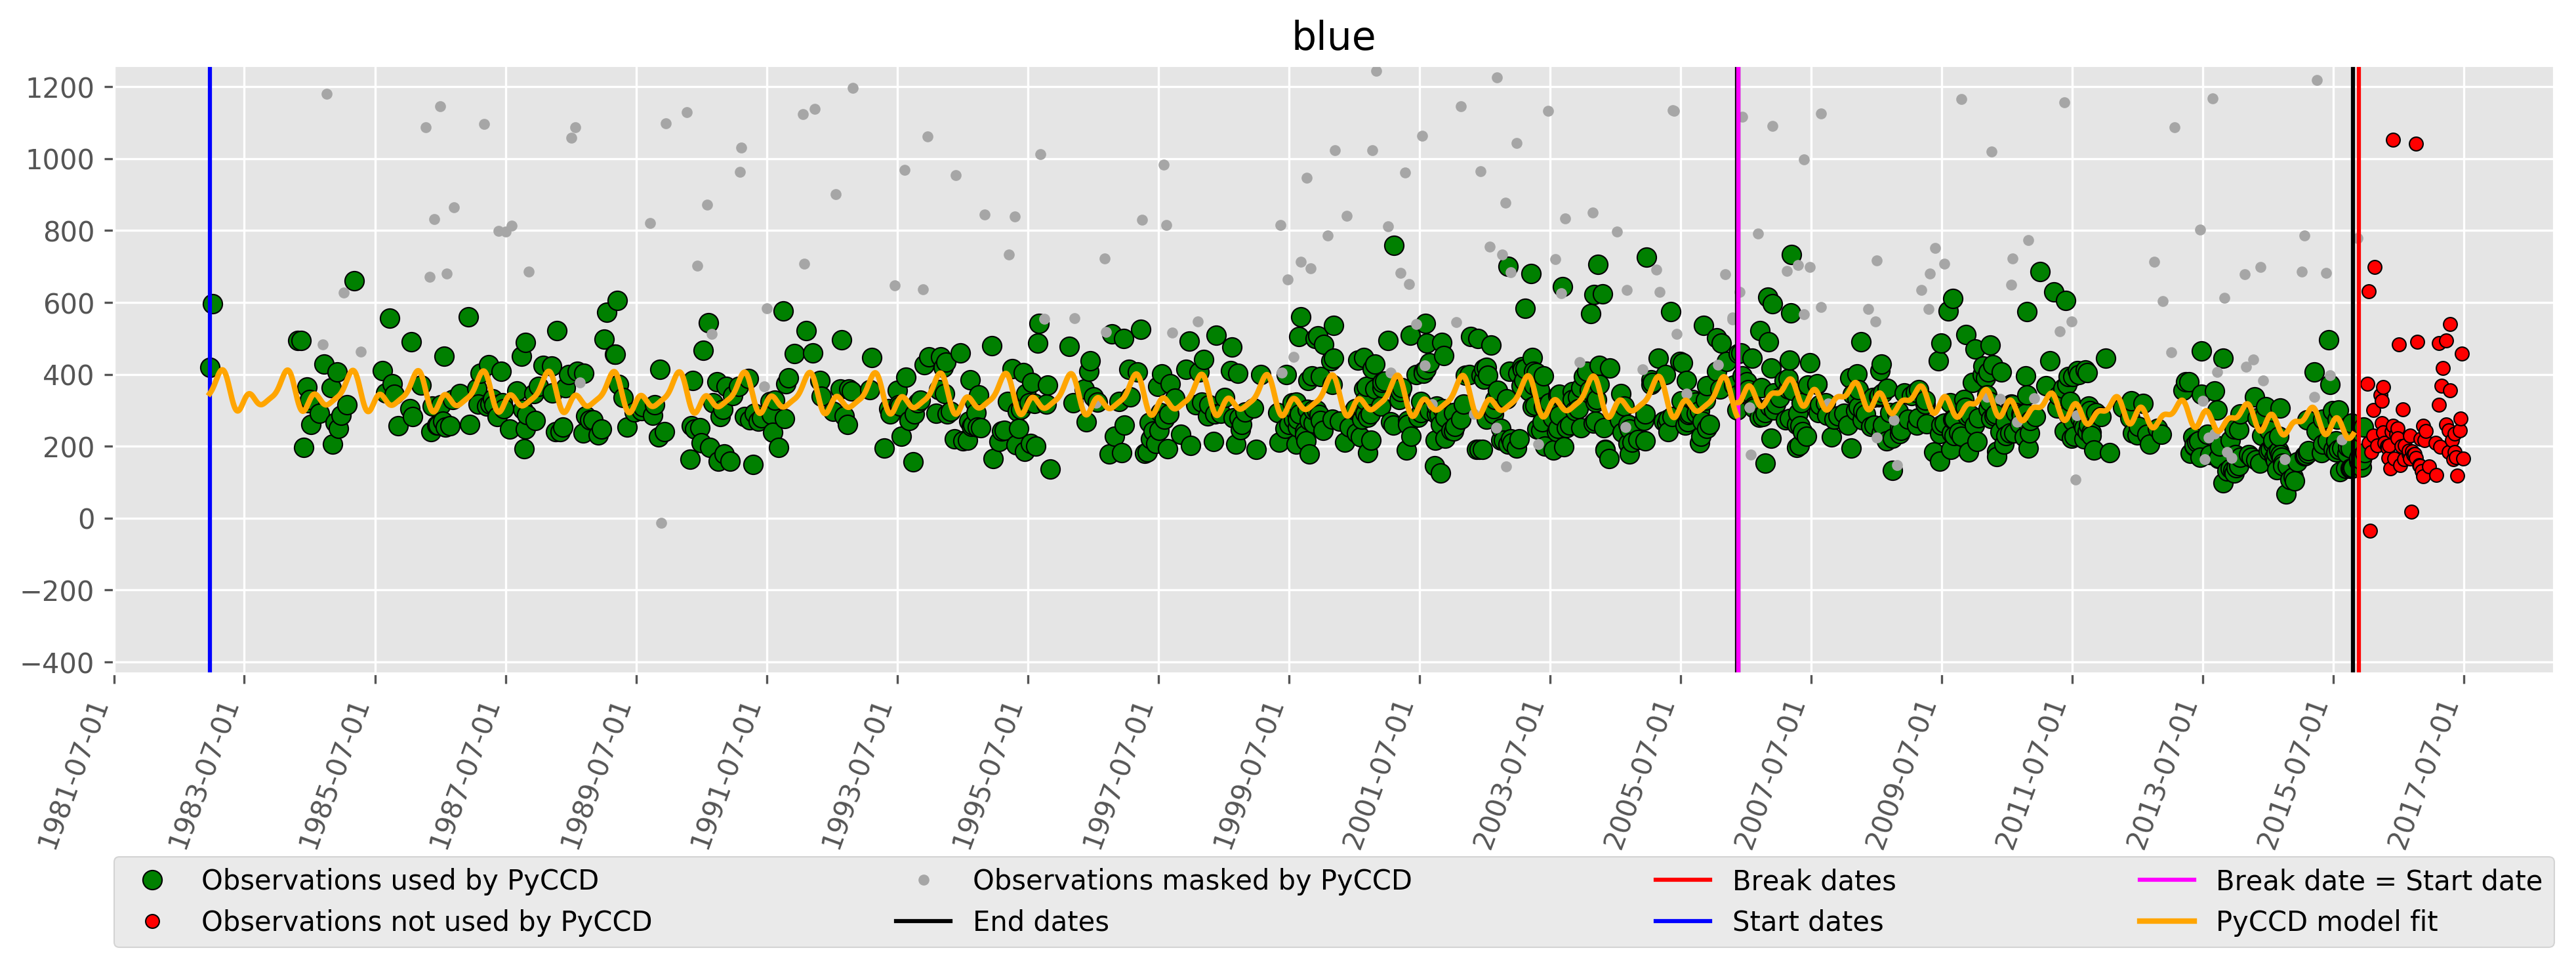

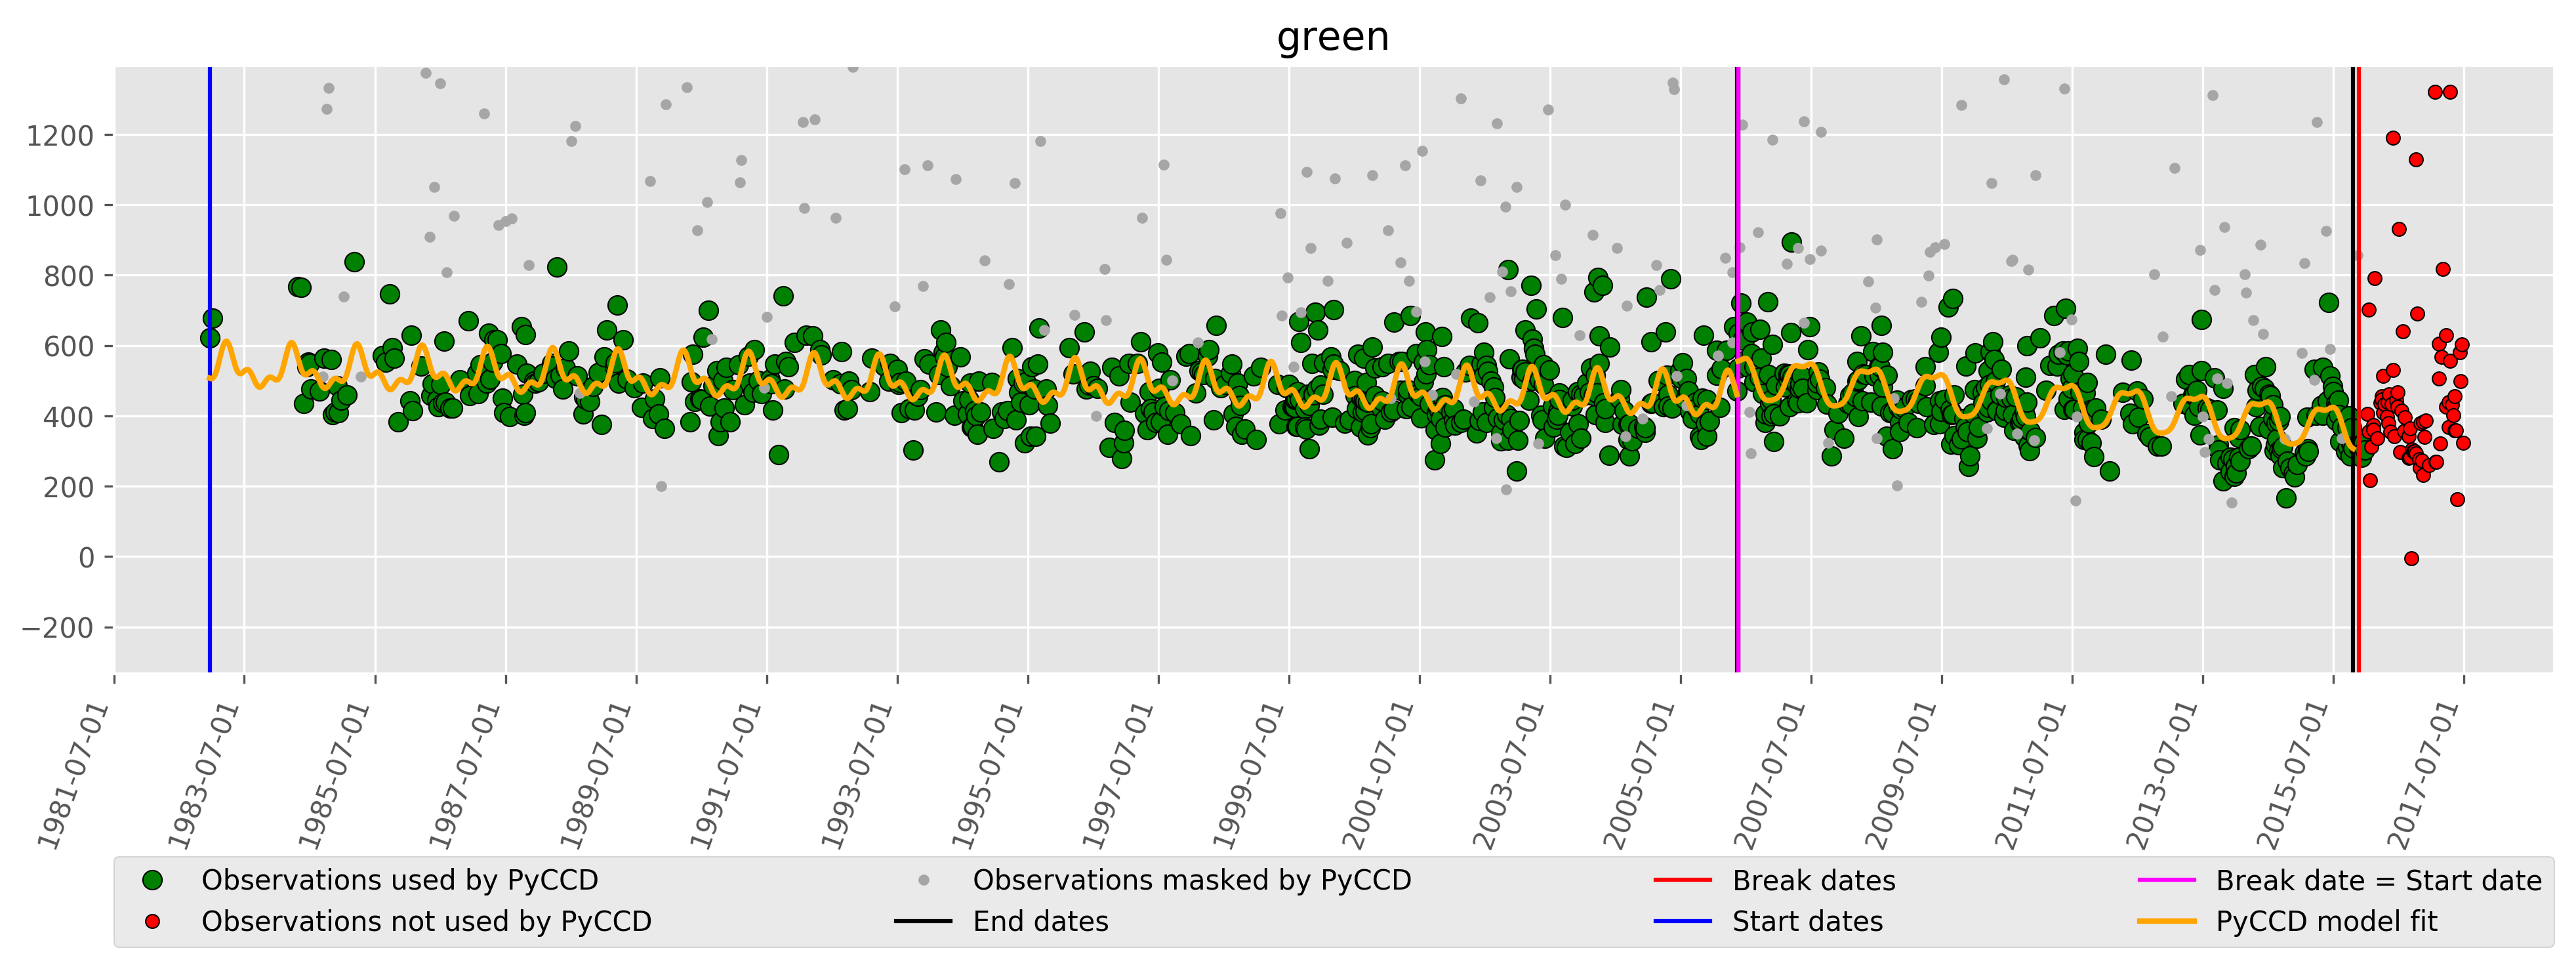

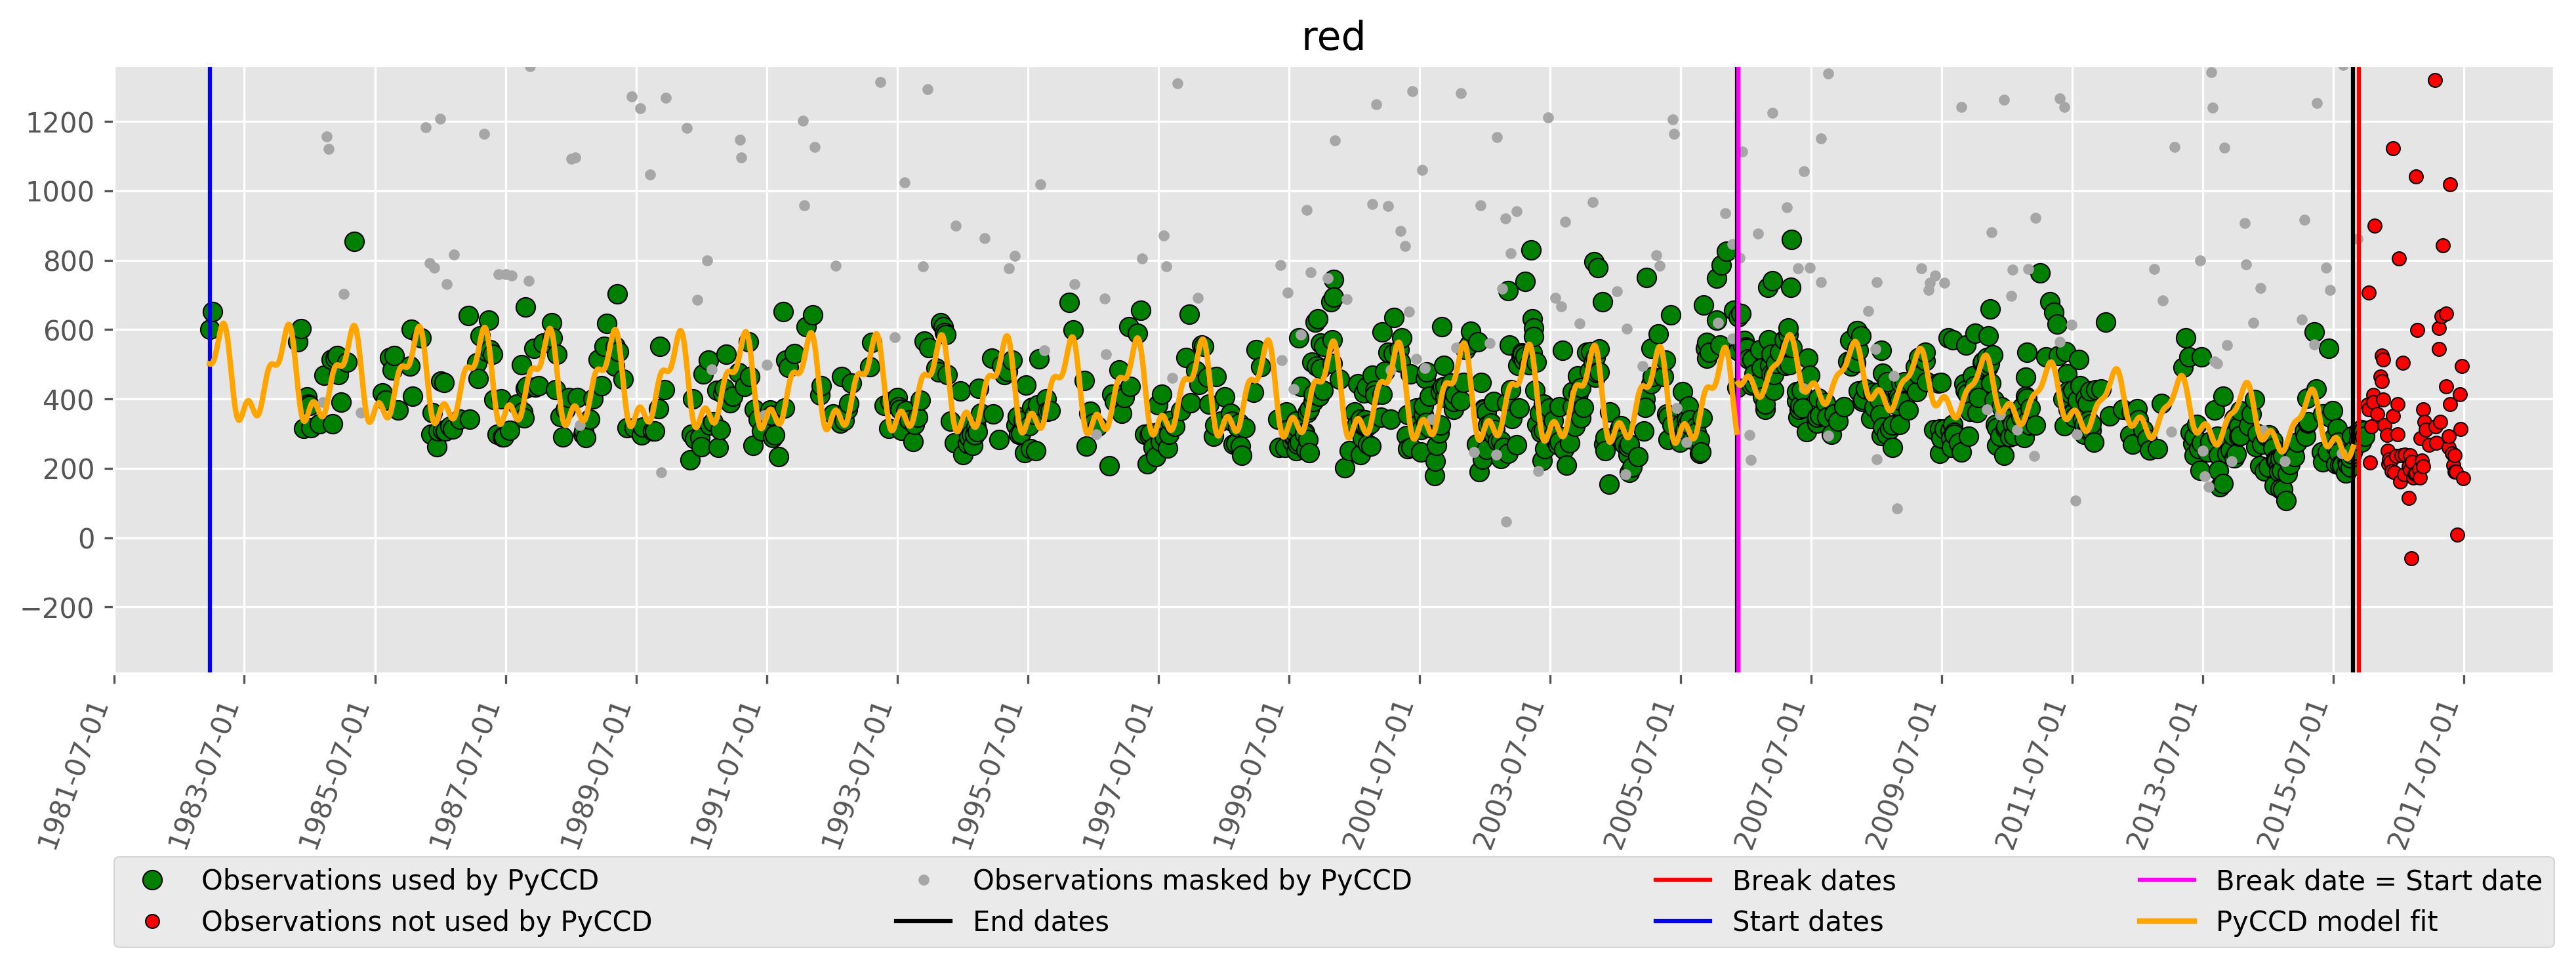

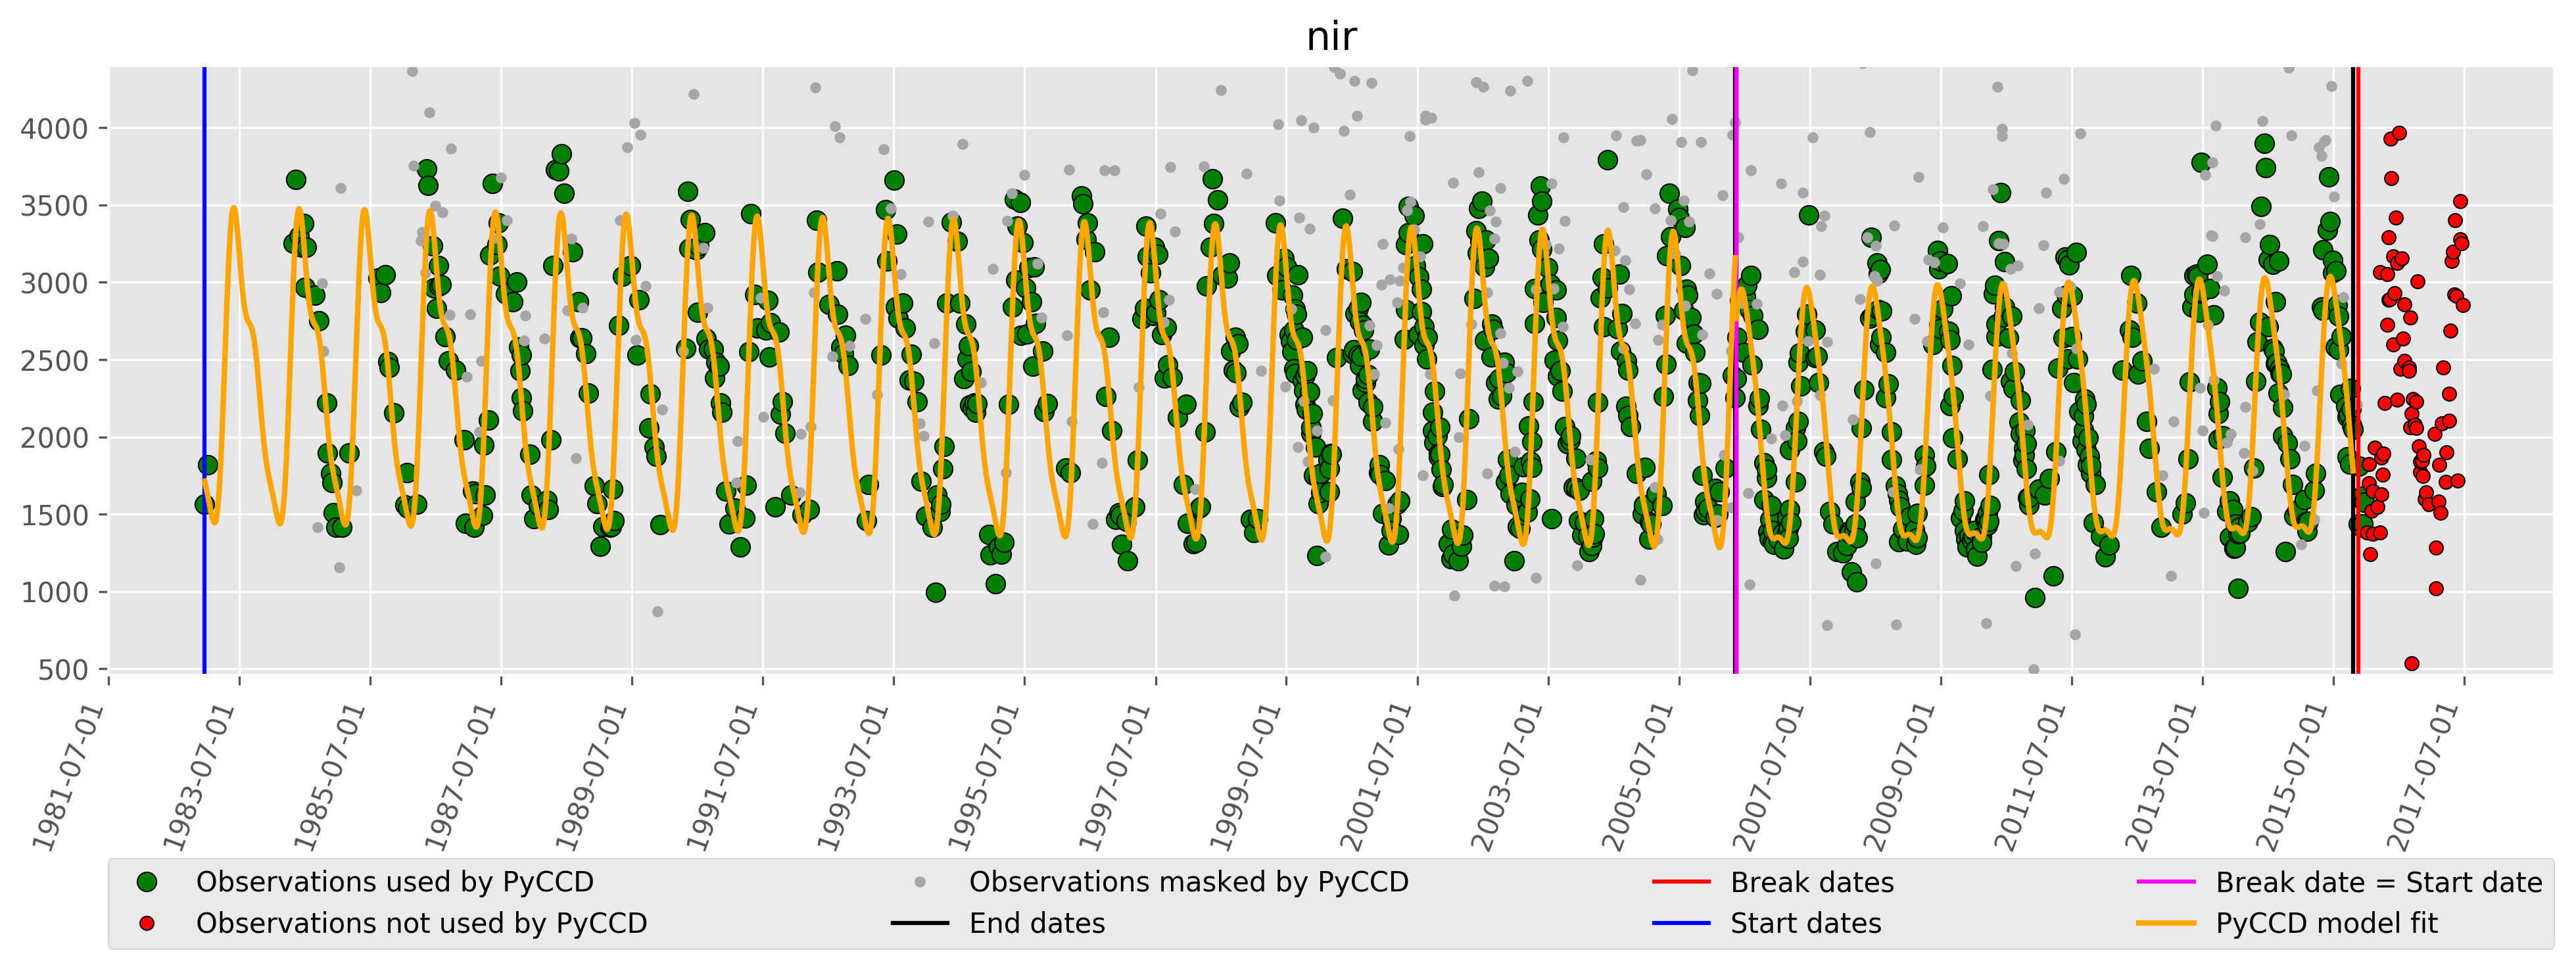

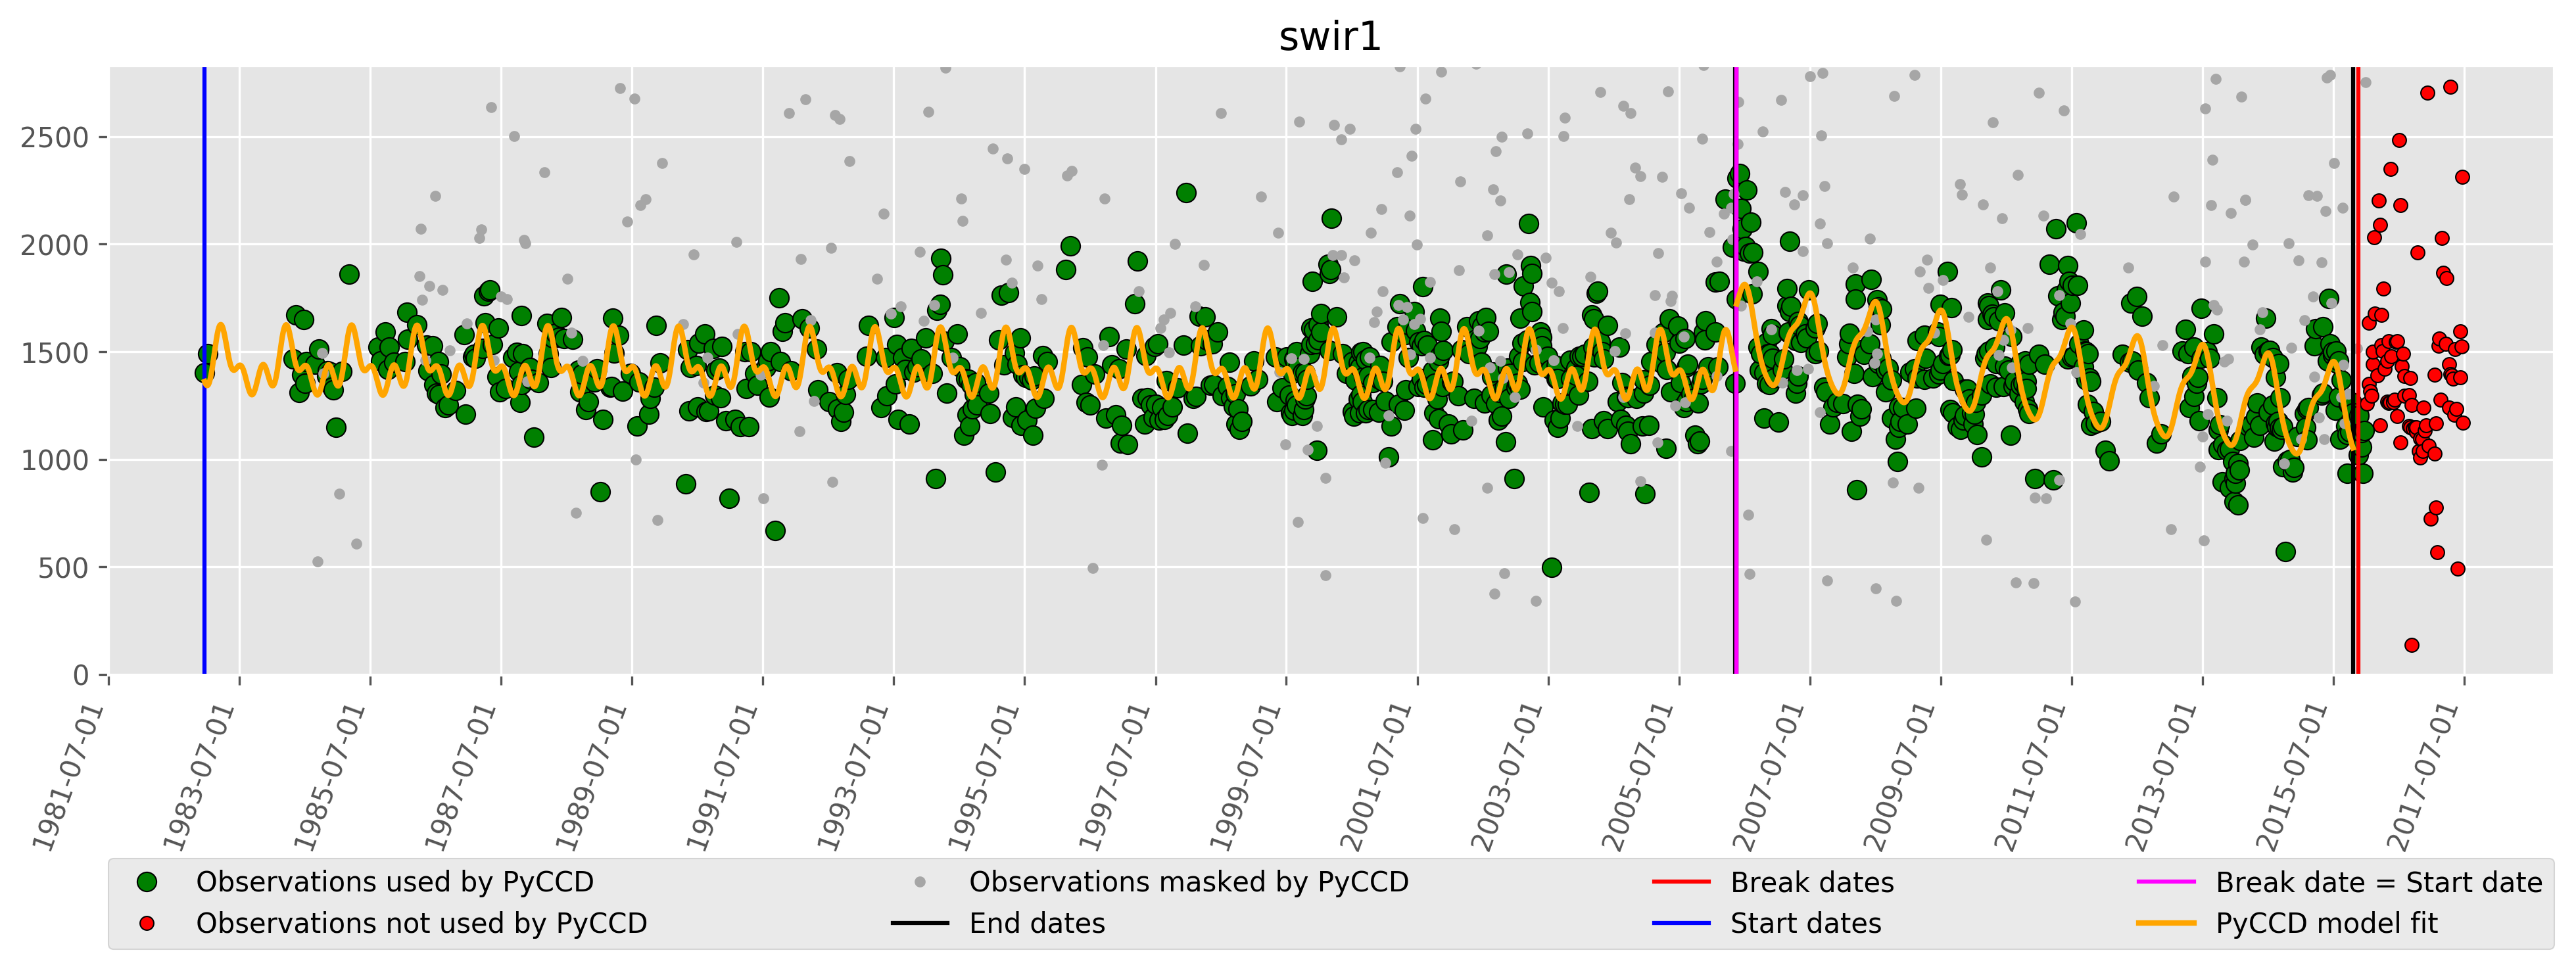

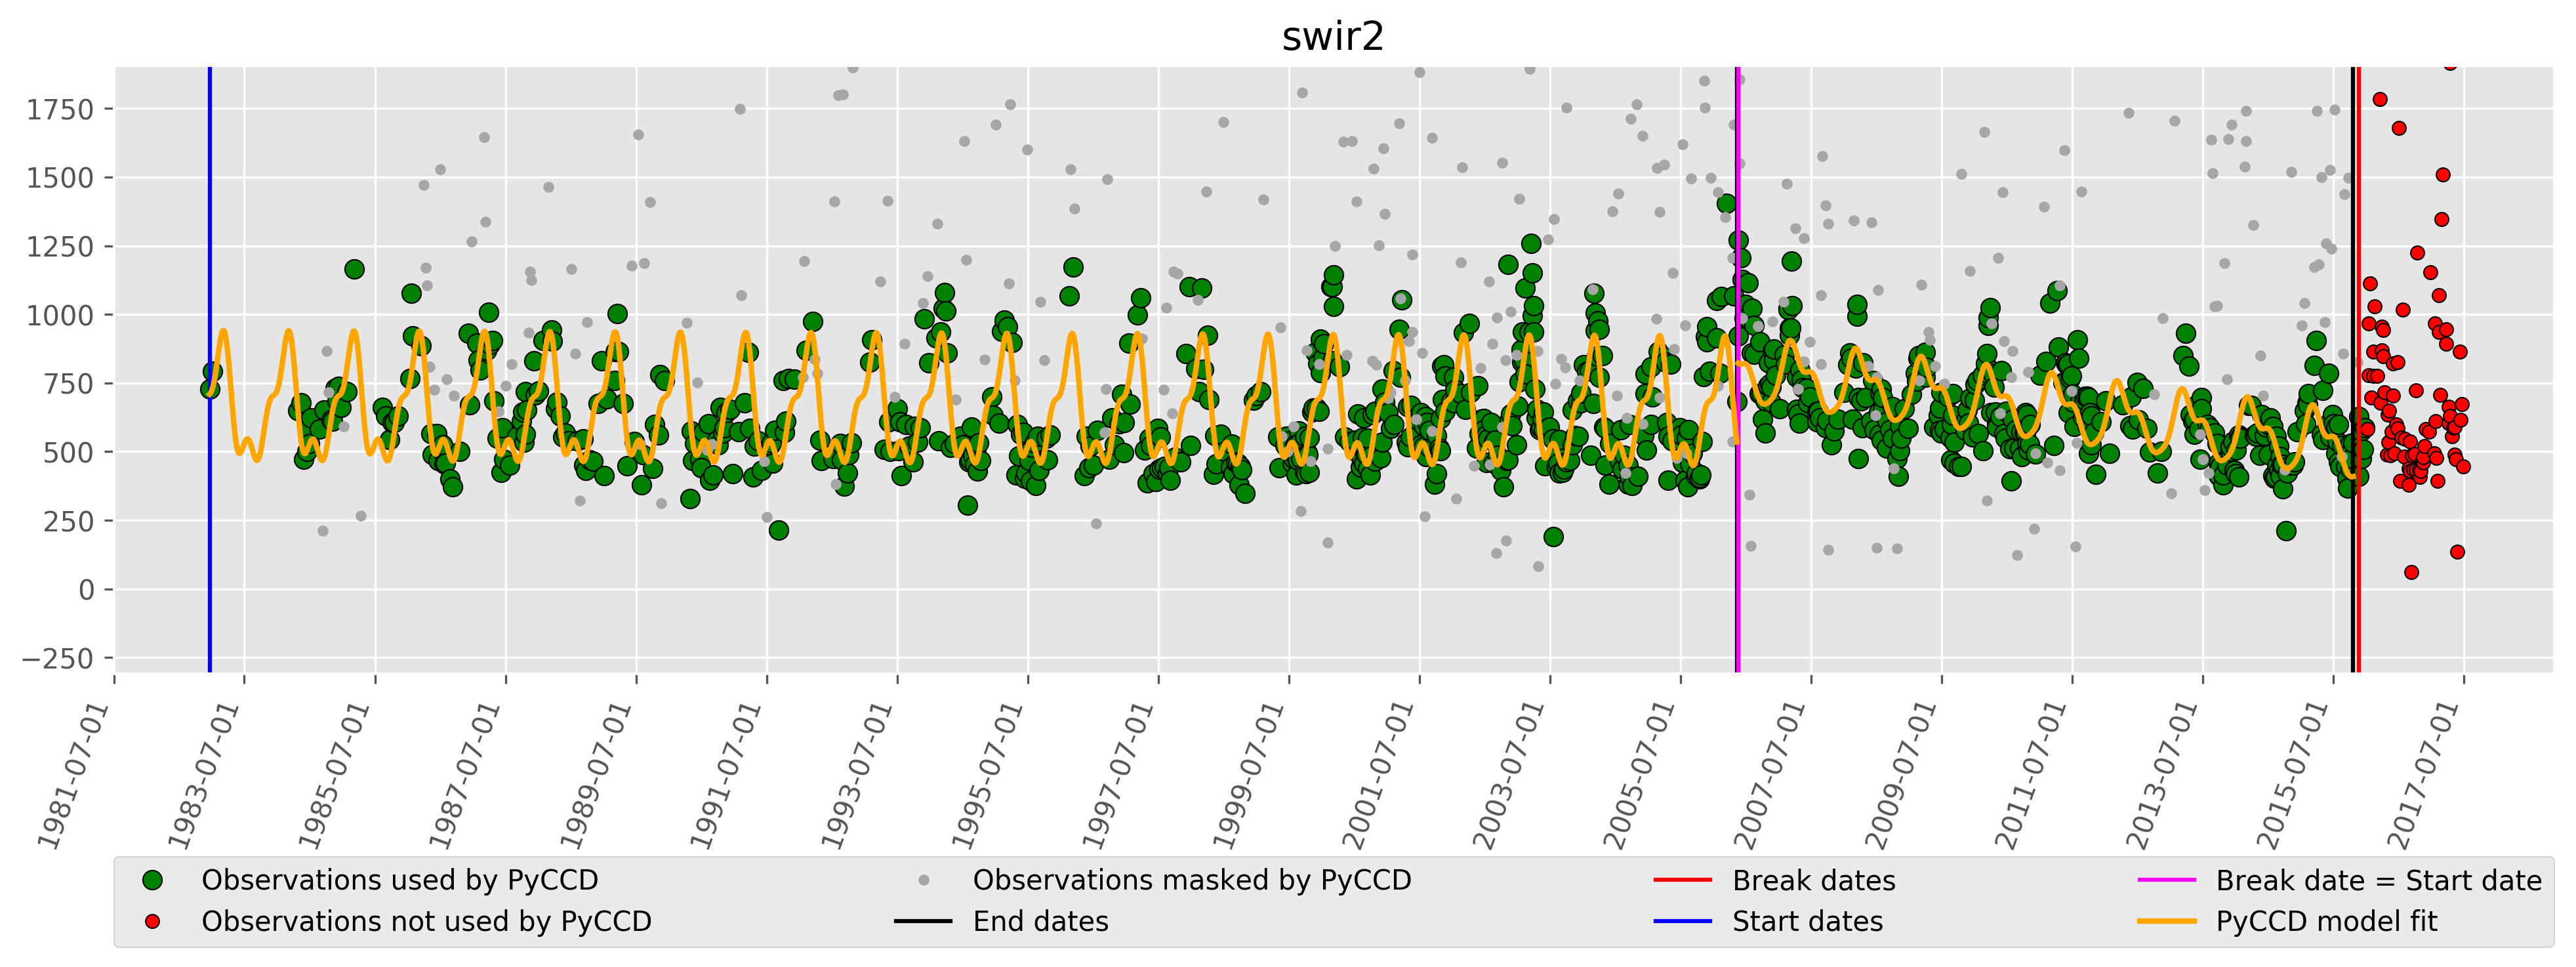

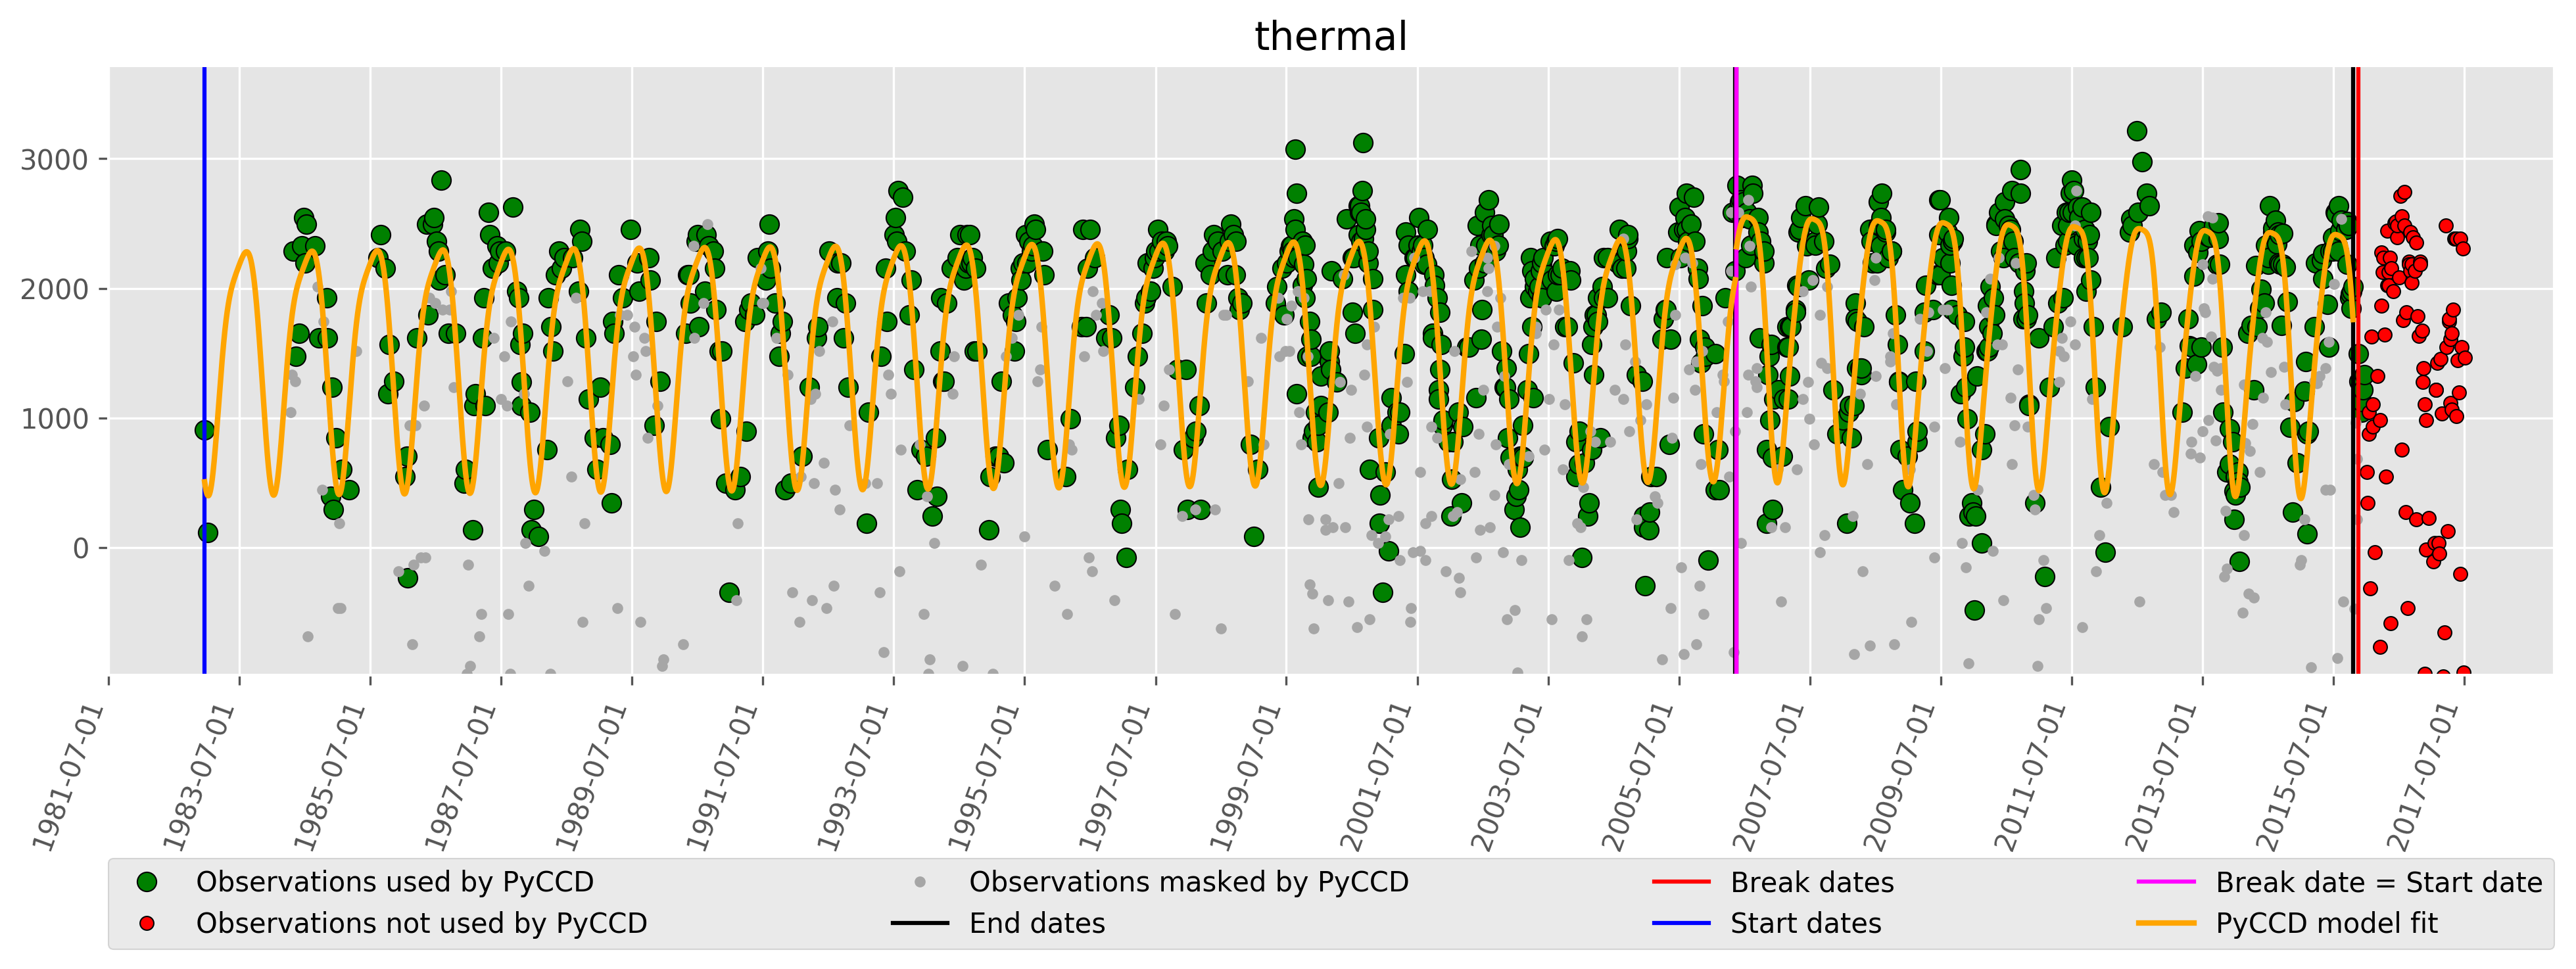

In [47]:
bands = ('blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'thermal')
band_info = {b: {'coefs': [], 'inter': [], 'pred': []} for b in bands}

mask = np.array(results['processing_mask'], dtype=bool)
#mask = np.array(test_results, dtype=bool)


print('Start Date: {0}\nEnd Date: {1}\n'.format(dt.datetime.fromordinal(dates[0]),
                                                dt.datetime.fromordinal(dates[-1])))

predicted_values = []
prediction_dates = []
break_dates = []
start_dates = []
end_dates = []

# get year values for labeling plots
year1 = str(dt.datetime.fromordinal(dates[0]))[:4]
year2 = str(dt.datetime.fromordinal(dates[-1]))[:4]
years = np.arange(int(year1), int(year2), 2)

for num, result in enumerate(results['change_models']):
    print('Result: {}'.format(num))
    print('Start Date: {}'.format(dt.date.fromordinal(result['start_day'])))
    print('End Date: {}'.format(dt.date.fromordinal(result['end_day'])))
    print('Break Date: {}'.format(dt.date.fromordinal(result['break_day'])))
    print('QA: {}'.format(result['curve_qa']))
    print('Change prob: {}'.format(result['change_probability']))
    
    days = np.arange(result['start_day'], result['end_day'] + 1)
    
    break_dates.append(result['break_day'])
    start_dates.append(result['start_day'])
    end_dates.append(result['end_day'])
    
    for b in bands:
        band_info[b]['inter'] = result[b]['intercept']
        band_info[b]['coefs'] = result[b]['coefficients']
        band_info[b]['pred'] = predicts(days, result[b]['coefficients'], result[b]['intercept'])
    
        intercept = result[b]['intercept']
        coef = result[b]['coefficients']
        prediction_dates.append(days)
        predicted_values.append(predicts(days, coef, intercept))
    

plt.style.use('ggplot')


# dates_plt is the same as dates_masked
# dates_plt = dates[mask]

# ****X-Axis Ticks and Labels****
# list of years
y = [yi for yi in range(1981, 2018, 2)]

# list of datetime objects with YYYY-MM-dd pattern
t = [dt.datetime(yx, 7, 1) for yx in y]

# list of ordinal time objects
ord_time = [dt.datetime.toordinal(tx) for tx in t]

# list of datetime formatted strings
x_labels = [str(dt.datetime.fromordinal(int(L)))[:10] if L != "0.0" and L != "" else "0" for L in ord_time]

total_mask = np.logical_and(mask, qa_in)


for num, b in enumerate(bands):
    fg = plt.figure(figsize=(16,9), dpi=300)
    a1 = fg.add_subplot(2, 1, 1, xlim=(min(dates)-100, max(dates)+500), ylim=(min(data_in[num, total_mask]) - 500, 
                                                                                 max(data_in[num, total_mask]) + 500))
    
    
    # data_plt = data[num, mask]
    
    # Observed values in PyCCD time range
    a1.plot(dates_in[total_mask], data_in[num, total_mask], 'go', ms=7, mec='k', mew=0.5, label="Observations used by PyCCD")
    
    # Observed values outside PyCCD time range
    a1.plot(dates_out[qa_out], data_out[num][qa_out], 'ro', ms=5, mec='k', mew=0.5, label="Observations not used by PyCCD")
    
    # Observed values masked out
    a1.plot(dates_in[~total_mask], data_in[num, ~total_mask], color="0.65", marker="o", linewidth=0, ms=3, 
             label="Observations masked by PyCCD")
    
    a1.set_title(f'{b}')

    # plot model break and start dates
    match_dates = [b for b in break_dates for s in start_dates if b==s]
    
    for ind, e in enumerate(end_dates): 
        if ind == 0:
            a1.axvline(e, color="black", label="End dates")
        
        else:
            a1.axvline(e, color="black")
            
    
    for ind, b in enumerate(break_dates): 
        if ind == 0:
            a1.axvline(b, color='r', label="Break dates")
        
        else:
            a1.axvline(b, color='r')
        
    for ind, s in enumerate(start_dates): 
        if ind ==0:
            a1.axvline(s, color='b', label="Start dates")
        
        else:
            a1.axvline(s, color='b')
            
    for ind, m in enumerate(match_dates):
        if ind == 0:
            a1.axvline(m, color="magenta", label="Break date = Start date")
        
        else:
            a1.axvline(m, color="magenta")

    # Predicted curves
    for c in range(0 , len(results["change_models"])):
        if c == 0:
            a1.plot(prediction_dates[c * len(bands) + num], predicted_values[c * len(bands) + num],
                   "orange", linewidth=2, label="PyCCD model fit")
        
        else:
            a1.plot(prediction_dates[c * len(bands) + num], predicted_values[c * len(bands) + num],
                   "orange", linewidth=2)
    
  
    # Add legend
    a1.legend(mode="expand", ncol=4, bbox_to_anchor=(0., -0.45, 1, 0.25), loc=8, borderaxespad=0.)
    
    # Add x-ticks and x-tick_labels 
    a1.set_xticks(ord_time)

    a1.set_xticklabels(x_labels, rotation=70, horizontalalignment="right")

